## Sensitivity Analysis: Sobol Method

---

This notebook will use the Sobol sensitivity analysis method to identify the most significant parameters using the same Phreeqc U sorption model from the previous notebook.

Sobol analysis accounts for non-linear relationships across the input variables by changing more than one at a time.

https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis

Parameter setup is identical to previous notebook

#### Set up initial parameters and uncertainty bounds

*pqcpath*: path to phreeqc.bat executable

*TDBfile*: name of phreeqc database file without file extension

*outfile*: name of phreeqc output file including file extension

*infile*: name of phreeqc input file including file extension

In [1]:
import os 
import numpy.random
from writeIOphreeqc import*
import matplotlib.pyplot as plt

# these are used when we run phreeqc in run_sims()
pqcpath = 'C:/Users/htzen/Desktop/phreeqc-3.7.0-15749-x64/bin/phreeqc'
TDBfile = 'llnl_Mahoney_updated'
outfile = 'Outputfile3.out'
infile = 'U_HFO_input3.txt'

# bounds from table 2 in Mahoney et. al.
pars    = ['!Hfo_sOUO2+!', '!Hfo_wOUO2+!', '!Hfo_wOUO2CO3-!', '!Hfo_wOUO2(CO3)2-3!']
lower = [1.62, 1.79, 8.75, 15.1]
upper = [5.85, 3.28, 9.32, 15.28]

# setting up values from experimental results for later plotting
exp_pH = [3.56041,4.07969,4.51985,5.00029,5.47929,5.93959]
exp_U = [0.099831,0.071537,0.029899,0.001774,0,0]


# extraneous verify function which can be a simple sanity check for longer lists
def verify(low, upp):
    """
    checks length and bounds of lists for correct format
    """
    if len(low) == len(upp):
        
        if all([low[i] <= upp[i] for i in range(len(low))]):
            print("verify: bounds check out")
            return True
        print("verify: error -- listed bounds are inconsistent")
        return False
    
    print("verify: error -- lists are different lenghts")
    return False



# searches for the '-find ' key in the input file to get the name of the .sel output file
# (assumes .sel file is in the current directory)
def find_opsel(infile):
    
    with open(infile, 'r') as f:
        for line in f.readlines():
            if line.find("-file ") > 0:
                return line[line.find("-file ")+len("-file "):-1]
            
    print("error: unable to find output file in {}".format(infile))
    return -1

# verify bounds and set phreeqc output to read
verify(lower, upper)
opsel = find_opsel(infile)
#print(opsel)

verify: bounds check out


#### Define general phreeqc simulation methods

In [2]:
# returns a matrix of random values between lower and upper
def get_random_values(lower, upper, num_iter):
    # lower, upper: lists of bounds to generate within
    # num_iter: number of sets to generate
    # return: num_iter by len(lower) matrix
    
    # generate 1st row
    matrix = np.zeros(len(lower))
    for i in range(len(lower)):
        matrix[i] = numpy.random.uniform(lower[i], upper[i])
        
    # generate more rows if needed
    if num_iter < 2:
        return [matrix]
    else:
        for j in range(num_iter-1):
            values = np.zeros(len(lower))
            for i in range(len(lower)):
                values[i] = numpy.random.uniform(lower[i], upper[i])
            matrix = np.vstack((matrix, values))
        return matrix

# runs a phreeqc simulation for each row of parameters in values_mtrx
# requires various path variables to be set correctly at beginning of file
def run_sims(values_mtrx, opsel, analytes=['pH', 'U']):
    # values_mtrx: matrix of values generated from get_random_values or similar function
    # analytes: list of element keywords to search for in .out file generated by phreeqc
    # opsel: path to the .sel file  
    # return: list of np arrays of [sim#, analyte1, analyte2...] (format is kind of awkward 
    #    but I can handle it with wrapper functions for now)
    
    obs_all = []
    for values in values_mtrx:        
        # enabling the below code can help verify phreeqc is correctly generating new output files
        # by deleting old output files before each run
#         if os.path.exists("Outputfile.out"):
#             os.remove("Outputfile.out")
#         if os.path.exists("U_HFO_Complexation_Output_Trial3.sel"):
#             os.remove("U_HFO_Complexation_Output_Trial3.sel")

        writeInput(TDBfile, pars, values)
        
        # the .read() here is essential because it tells python to wait for phreeqc to
        # finish running before executing following code.
        os.popen(pqcpath+' '+infile+' '+outfile+' '+TDBfile+'.txt').read()
        
        # reads phreeqc results and appends to running list
        obs = readOutput(opsel, analytes)
        obs_all.append(obs)

        # enabling following code can help check if the output files are updating correctly
#         import shutil
#         shutil.copyfile('U_HFO_Complexation_Output_Trial3.sel', 'U_HFO_Complexation_Output_Trial3_{}.sel'.format(itr))
#         shutil.copyfile('llnl_Mahoney_updated.txt', 'llnl_Mahoney_updated{}.txt'.format(itr))

    return obs_all


#### Setting up general SALib parameters and methods

We will use the sobol analysis functions from the Sensitivity Analysis Library package to find which of the four initial parameters are the most significant.

https://salib.readthedocs.io/en/latest/api.html#method-of-morris

---
large mean (mu) = large response to perturbation

large sigma = elementary effects depend highly on choice of sample point (response is non-linear)

small sigma = EEs similar for different selected sample points; effect of parameter independent of other parameter values

In [3]:
from SALib.sample import morris as ssm
from SALib.analyze import morris as sam

# Define the model inputs
problem = {
    'num_vars': 4,
    'names': ['!Hfo_sOUO2+!', '!Hfo_wOUO2+!', '!Hfo_wOUO2CO3-!', '!Hfo_wOUO2(CO3)2-3!'],
    'bounds': [[1.62, 5.85], [1.79, 3.28], [8.75, 9.32], [15.2, 15.28]]
}


# runs run_sims and formats analyte results into matrix of iteration# and observation
# save matrix results into file
# write function to load file later
def ensemble_sim(params, opsel, analyte=['U'], savefile=''):
    # analyte: single analyte to measure; name of colummn from phreeqc .sel output file
    # savefile: saves results array to a .npy file. needs to contain '.npy' in name
    #    also saves params array as 'savefile_p.npy'
    # return: #simulations by #observations matrix

    sims = run_sims(params, opsel, analyte)
    
    # [0][1] index of run_sims will be the list of analyte values 
    output = sims[0][1]
    for sim in sims[1:]:
        output = np.vstack((output, sim[1]))
    
    if savefile:
        if ".npy" in savefile:
            np.save(savefile, output)
            sfp = savefile.split(".npy")[0]+"_p.npy"
            np.save(sfp, params)
        else:
            print("error: savefile name \"{}\" does not contain '.npy': Results not saved."\
                  .format(savefile))
    
    return output

def load_sim(savefile):
    if ".npy" not in savefile:
        print("error: file name \"{}\" does not contain '.npy'".format(savefile))
        return
    return np.load(savefile)

# generates a list of morris result dictionaries per parameter
def morris_analysis(X, Y):
    # Perform Morris analysis on first parameter
    morris_result = [sam.analyze(problem, X, Y.T[0], conf_level=0.95, num_levels=4,
                         print_to_console=False)]

    # Storing the sensitivity indices as a list of dictionaries
    # each dictionary represents the results for one observation
    for i_obs in range(1, np.shape(Y)[1]):
        Si = sam.analyze(problem, X, Y.T[i_obs], conf_level=0.95, num_levels=4, 
                         print_to_console=False)
        morris_result.append(Si)

#     # Making a matrix of observations by parameters
#     mu_all = morris_result[0].get("mu")
#     for obs in morris_result[1:]:
#         mu_all = np.vstack((mu_all, obs.get("mu")))
        
    return morris_result


def dicts_to_mtrx(dlist, key):
    # helper function to convert SALib dictionary results back into matrices
    mtrx = dlist[0].get(key)
    for d in dlist[1:]:
        mtrx = np.vstack((mtrx, d.get(key)))
    return mtrx

def morris_summary(morris_res):
    # returns SALib dictionary results in matrix form by (parameter, simulation#)
    return dicts_to_mtrx(morris_res, "mu").T, dicts_to_mtrx(morris_res, "mu_star").T, \
        dicts_to_mtrx(morris_res, "sigma").T, dicts_to_mtrx(morris_res, "mu_star_conf").T

#### Setting up Sobol parameters and methods

In [4]:
from SALib.sample import saltelli as sss
from SALib.analyze import sobol as sas

def sobol_analysis(X, Y):
    # Perform sobol analysis on parameter 1
    sobol_result = [sas.analyze(problem, Y.T[0], conf_level=0.95, print_to_console=False)]

    # Storing the sensitivity indices as a list of dictionaries
    # each dictionary represents the results for one observation
    # returning this list instead gets a lot more information, but it might not
    # be necessary for now
    for i_obs in range(1, np.shape(Y)[1]):
        Si = sas.analyze(problem, Y.T[i_obs], conf_level=0.95, print_to_console=False)
        sobol_result.append(Si)
        
    return sobol_result

In [5]:
sob_traj = 256
X = sss.sample(problem, sob_traj)
X = load_sim("7_22sim_p.npy")
# Y = ensemble_sim(X, opsel, savefile="7_22sim.npy")
Y = load_sim("7_22sim.npy")
sr = sobol_analysis(X, Y)


[]

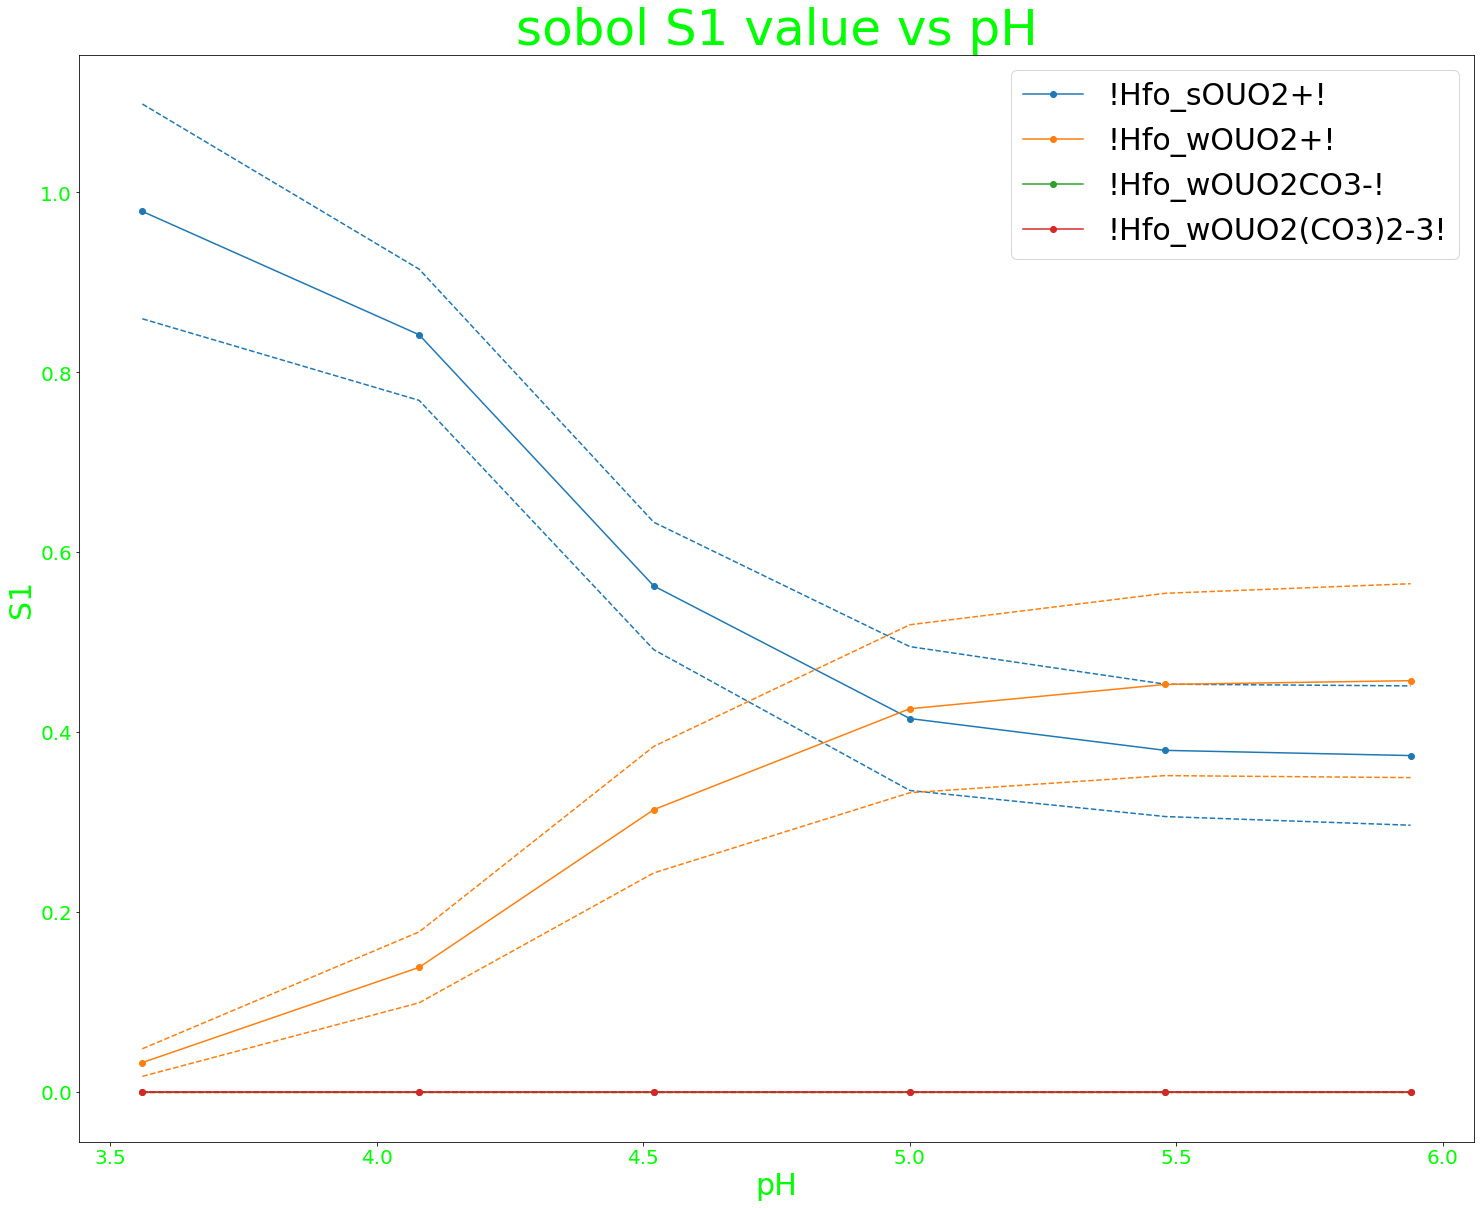

In [6]:
sb_s1 = dicts_to_mtrx(sr, "S1").T
sb_s1c = dicts_to_mtrx(sr, "S1_conf").T
f, ax = plt.subplots(figsize=[25,20])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("sobol S1 value vs pH", fontdict={'fontsize': 50, 'color': 'lime'})
plt.xlabel('pH', fontdict={'fontsize': 30, 'color': 'lime'})
plt.xticks(fontsize = 20, color = 'lime')
plt.ylabel('S1', fontdict={'fontsize': 30, 'color': 'lime'})
plt.yticks(fontsize = 20, color = 'lime')

for i in range(len(sb_s1)):
    ax.plot(exp_pH, sb_s1[i], marker='o', label="{}".format(pars[i]))
    ax.plot(exp_pH, sb_s1[i]-sb_s1c[i]/2, ls='--', color=ax.lines[-1].get_color())
    ax.plot(exp_pH, sb_s1[i]+sb_s1c[i]/2, ls='--', color=ax.lines[-2].get_color())
ax.legend(fontsize=30)
ax.plot()

[]

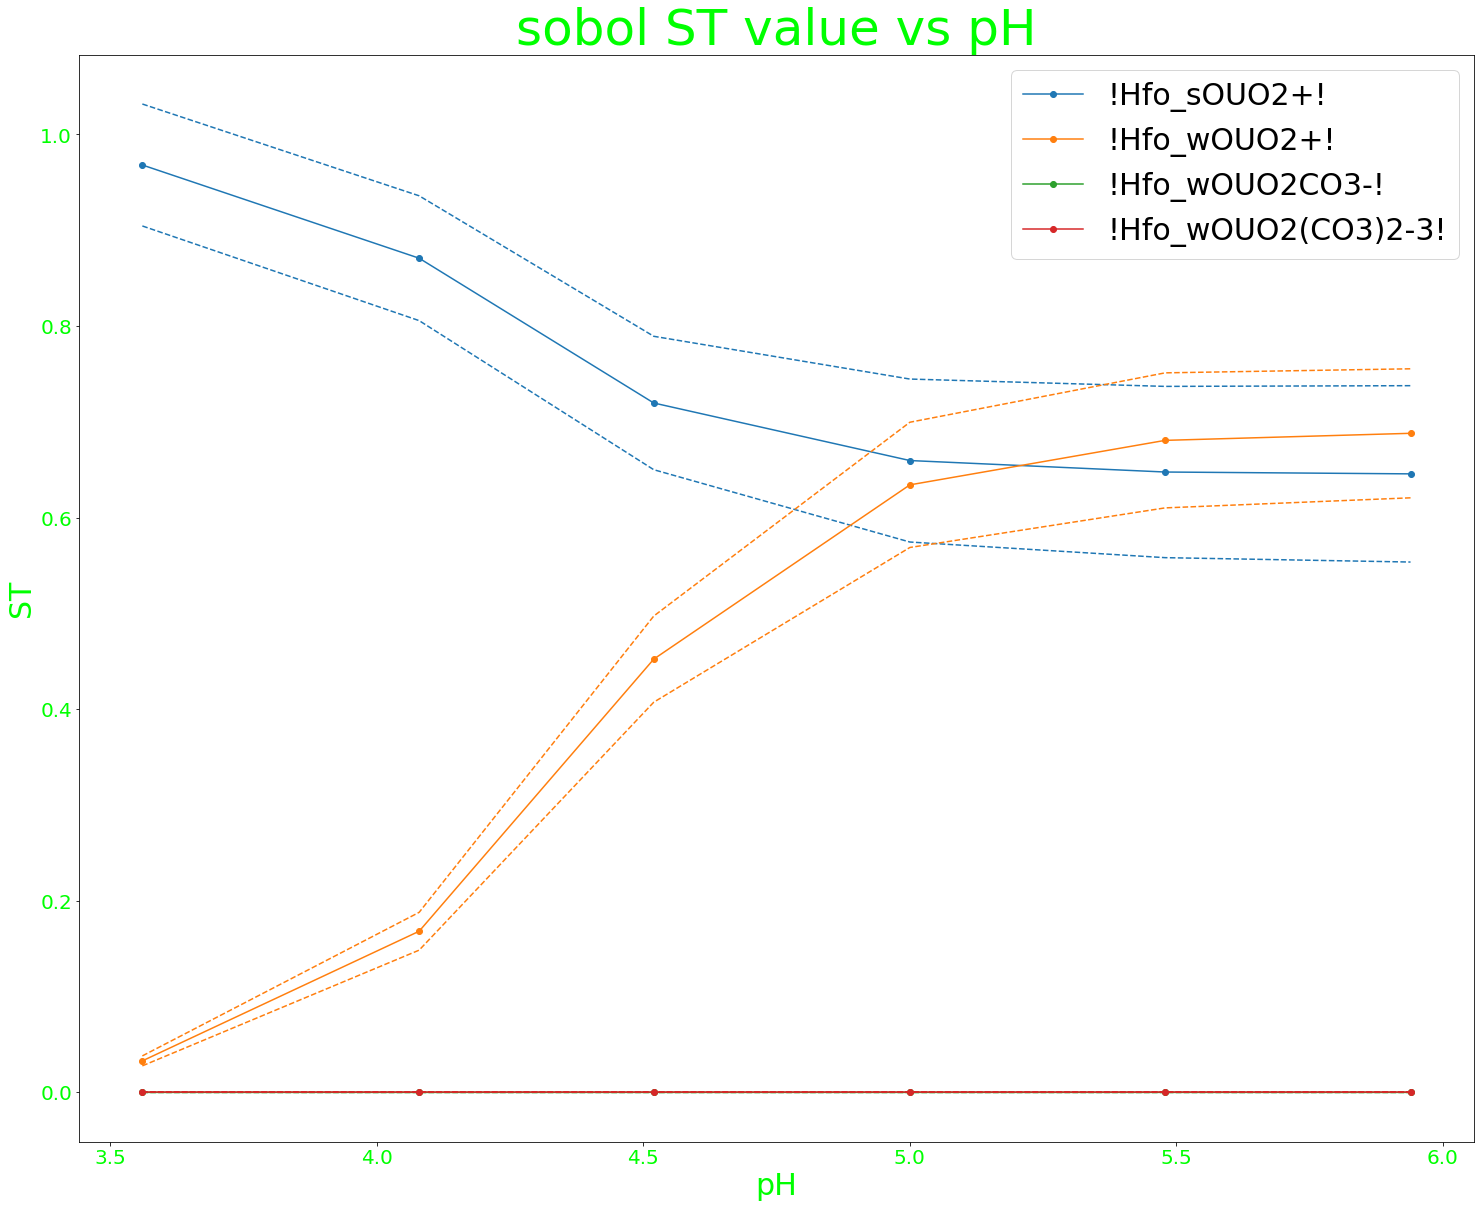

In [7]:
sb_st = dicts_to_mtrx(sr, "ST").T
sb_stc = dicts_to_mtrx(sr, "ST_conf").T
f, ax = plt.subplots(figsize=[25,20])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("sobol ST value vs pH", fontdict={'fontsize': 50, 'color': 'lime'})
plt.xlabel('pH', fontdict={'fontsize': 30, 'color': 'lime'})
plt.xticks(fontsize = 20, color = 'lime')
plt.ylabel('ST', fontdict={'fontsize': 30, 'color': 'lime'})
plt.yticks(fontsize = 20, color = 'lime')

for i in range(len(sb_st)):
    ax.plot(exp_pH, sb_st[i], marker='o', label="{}".format(pars[i]))
    ax.plot(exp_pH, sb_st[i]-sb_stc[i]/2, ls='--', color=ax.lines[-1].get_color())
    ax.plot(exp_pH, sb_st[i]+sb_stc[i]/2, ls='--', color=ax.lines[-2].get_color())
ax.legend(fontsize=30)
ax.plot()